In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import pickle

def load_daily_data(file_path):
    p = Path(file_path)
    df = pd.read_csv(p, parse_dates=["Date"])
    df.set_index("Date", inplace=True)
    if df.index.tz is None:
        df.index = df.index.tz_localize("UTC")
    for col in ["Close", "Adj Close", "Open", "High", "Low", "Vol", "Volume"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    # Standardize volume column: prefer Volume, then Vol
    if "Volume" in df.columns:
        df["volume_raw"] = df["Volume"]
    elif "Vol" in df.columns:
        df["volume_raw"] = df["Vol"]
    else:
        df["volume_raw"] = np.nan
    return df.sort_index()

def load_minute_data(file_paths):
    frames = []
    for file_path in file_paths:
        p = Path(file_path)
        df = pd.read_csv(p)
        if "Open time" not in df.columns:
            raise KeyError(f"{p} missing 'Open time' column")
        df["Open time"] = pd.to_datetime(df["Open time"], utc=True)
        df.rename(columns={"Open time": "Date"}, inplace=True)
        for col in ["Open", "High", "Low", "Close", "Volume"]:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors="coerce")
        df.set_index("Date", inplace=True)
        frames.append(df.sort_index())
    combined_df = pd.concat(frames).sort_index()
    return combined_df

def load_announcement_data(file_path):
    p = Path(file_path)
    if p.suffix.lower() == ".csv":
        df = pd.read_csv(p)
    elif p.suffix.lower() == ".xlsx":
        df = pd.read_excel(p)
    else:
        raise ValueError("Unsupported file type")
    # Automatically detect date column
    candidates = ["Date", "Release_Date", "Release Date", "DATE", "Time", "Datetime", "AnnouncementTime"]
    date_col = None
    lower = {c.lower(): c for c in df.columns}
    for c in candidates:
        if c in df.columns:
            date_col = c; break
        if c.lower() in lower:
            date_col = lower[c.lower()]; break
    if date_col is None:
        raise KeyError(f"{p} no date column found, actual columns: {list(df.columns)}")

    df[date_col] = pd.to_datetime(df[date_col], errors="coerce", utc=True)
    df.rename(columns={date_col: "Date"}, inplace=True)
    df.set_index("Date", inplace=True)
    return df.sort_index()

# === Change to actual filenames in current directory ===
daily_assets = {
    "AZN": load_daily_data("./data/AZN.L_unadjusted.csv"),
    "BP": load_daily_data("./data/BP.L_unadjusted.csv"),
    "BTC_USD": load_daily_data("./data/BTC-USD_unadjusted.csv"),
    "ETH_USD": load_daily_data("./data/ETH-USD_unadjusted.csv"),
    "HSBA": load_daily_data("./data/HSBA.L_unadjusted.csv"),
    "FTSE": load_daily_data("./data/^FTSE_unadjusted.csv"),
}

btc_minute_files = [f"./data/BTCUSDT_1m_2024-{month:02d}_unadjusted.csv" for month in range(1, 13)]
eth_minute_files = [f"./data/ETHUSDT_1m_2024-{month:02d}_unadjusted.csv" for month in range(1, 13)]

minute_assets = {
    "BTCUSDT_1m": load_minute_data(btc_minute_files),
    "ETHUSDT_1m": load_minute_data(eth_minute_files),
}

announcements = {
    "CPI":  load_announcement_data("./data/US_Core_CPI_MoM_2015_2024.xlsx"),
    "FOMC": load_announcement_data("./data/US_Fed_FOMC_RateDecision_2015_2024.xlsx"),
    "NFP":  load_announcement_data("./data/US_NFP_2015_2024_simple_K.xlsx"),
}

# Save to current directory
with open("daily_assets.pkl", "wb") as f:
    pickle.dump(daily_assets, f)
with open("minute_assets.pkl", "wb") as f:
    pickle.dump(minute_assets, f)
with open("announcements.pkl", "wb") as f:
    pickle.dump(announcements, f)

print("Data loaded and saved successfully.")



Data loaded and saved successfully.


In [3]:
import pandas as pd
import numpy as np
import pickle

# Load pkl files from current directory
with open("daily_assets.pkl", "rb") as f:
    daily_assets = pickle.load(f)
with open("minute_assets.pkl", "rb") as f:
    minute_assets = pickle.load(f)
with open("announcements.pkl", "rb") as f:
    announcements = pickle.load(f)

# Ensure announcement index is UTC-aware
for ann_type in announcements:
    if announcements[ann_type].index.tz is None:
        announcements[ann_type].index = announcements[ann_type].index.tz_localize("UTC")

def calculate_metrics(df):
    out = df.copy()
    out["returns"] = out["Close"].pct_change()
    out["volatility"] = out["returns"].rolling(window=5, min_periods=5).std()
    # Standardize volume: minute uses Volume, daily uses volume_raw
    if "Volume" in out.columns:
        out["volume"] = out["Volume"]
    elif "volume_raw" in out.columns:
        out["volume"] = out["volume_raw"]
    else:
        out["volume"] = np.nan
    return out

processed_daily_data = {k: calculate_metrics(v.copy()) for k, v in daily_assets.items()}
processed_minute_data = {k: calculate_metrics(v.copy()) for k, v in minute_assets.items()}

def run_event_study_raw(data, announcement_dates, window_type="daily"):
    """
    Return raw abnormal value lists (no t-test here).
    daily estimation window [-65,-6], event window [-5,+5];
    minute estimation window [-300,-61], event window [-60,+60]
    """
    results = {}
    for ann_type, ann_df in announcement_dates.items():
        type_results = {}
        for asset_name, df in data.items():
            res = {"abnormal_returns": [], "abnormal_volatility": [], "abnormal_volume": []}
            for ann_time in ann_df.index:
                if window_type == "daily":
                    est_s, est_e = ann_time - pd.Timedelta(days=65), ann_time - pd.Timedelta(days=6)
                    evt_s, evt_e = ann_time - pd.Timedelta(days=5),  ann_time + pd.Timedelta(days=5)
                else:
                    est_s, est_e = ann_time - pd.Timedelta(minutes=300), ann_time - pd.Timedelta(minutes=61)
                    evt_s, evt_e = ann_time - pd.Timedelta(minutes=60),  ann_time + pd.Timedelta(minutes=60)

                est = df.loc[(df.index >= est_s) & (df.index <= est_e)]
                evt = df.loc[(df.index >= evt_s) & (df.index <= evt_e)]
                if est.empty or evt.empty:
                    continue

                normal_ret = est["returns"].mean()
                normal_vol = est["volatility"].mean()
                normal_volm = est["volume"].mean()

                res["abnormal_returns"].extend((evt["returns"] - normal_ret).dropna().tolist())
                res["abnormal_volatility"].extend((evt["volatility"] - normal_vol).dropna().tolist())
                res["abnormal_volume"].extend((evt["volume"] - normal_volm).dropna().tolist())
            type_results[asset_name] = res
        results[ann_type] = type_results
    return results

# Run and save "raw abnormal value results"
daily_event_study_results  = run_event_study_raw(processed_daily_data, announcements, window_type="daily")
minute_event_study_results = run_event_study_raw(processed_minute_data, announcements, window_type="minute")

with open("daily_event_study_results.pkl", "wb") as f:
    pickle.dump(daily_event_study_results, f)
with open("minute_event_study_results.pkl", "wb") as f:
    pickle.dump(minute_event_study_results, f)

# Also save processed data (for regression use)
with open("processed_daily_data.pkl", "wb") as f:
    pickle.dump(processed_daily_data, f)
with open("processed_minute_data.pkl", "wb") as f:
    pickle.dump(processed_minute_data, f)

print("Event study complete and results saved.")



C:\Users\王若禹\AppData\Local\Temp\ipykernel_45924\1340334909.py:20: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  out["returns"] = out["Close"].pct_change()
C:\Users\王若禹\AppData\Local\Temp\ipykernel_45924\1340334909.py:20: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  out["returns"] = out["Close"].pct_change()
C:\Users\王若禹\AppData\Local\Temp\ipykernel_45924\1340334909.py:20: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not

Event study complete and results saved.


In [4]:
import pandas as pd
import numpy as np
import pickle
from scipy import stats

with open("daily_event_study_results.pkl", "rb") as f:
    daily_results = pickle.load(f)
with open("minute_event_study_results.pkl", "rb") as f:
    minute_results = pickle.load(f)

def perform_t_test(series_like):
    s = pd.Series(series_like, dtype="float64").dropna()
    if len(s) == 0:
        return np.nan, np.nan, np.nan
    t_stat, p_val = stats.ttest_1samp(s, 0.0)
    return s.mean(), t_stat, p_val

# Daily
daily_statistical_results = {}
for ann_type, assets_data in daily_results.items():
    daily_statistical_results[ann_type] = {}
    for asset_name, metrics_data in assets_data.items():
        daily_statistical_results[ann_type][asset_name] = {}
        for metric_name, abnormal_list in metrics_data.items():
            mean_abn, t_stat, p_val = perform_t_test(abnormal_list)
            daily_statistical_results[ann_type][asset_name][metric_name] = {
                "mean_abnormal": mean_abn,
                "t_statistic": t_stat,
                "p_value": p_val,
            }

# Minute
minute_statistical_results = {}
for ann_type, assets_data in minute_results.items():
    minute_statistical_results[ann_type] = {}
    for asset_name, metrics_data in assets_data.items():
        minute_statistical_results[ann_type][asset_name] = {}
        for metric_name, abnormal_list in metrics_data.items():
            mean_abn, t_stat, p_val = perform_t_test(abnormal_list)
            minute_statistical_results[ann_type][asset_name][metric_name] = {
                "mean_abnormal": mean_abn,
                "t_statistic": t_stat,
                "p_value": p_val,
            }

with open("daily_statistical_results.pkl", "wb") as f:
    pickle.dump(daily_statistical_results, f)
with open("minute_statistical_results.pkl", "wb") as f:
    pickle.dump(minute_statistical_results, f)

print("Statistical analysis completed and results saved.")



Statistical analysis completed and results saved.


In [7]:
import pandas as pd
import statsmodels.api as sm
import pickle

with open("processed_daily_data.pkl", "rb") as f:
    processed_daily_data = pickle.load(f)
with open("processed_minute_data.pkl", "rb") as f:
    processed_minute_data = pickle.load(f)
with open("announcements.pkl", "rb") as f:
    announcements_data = pickle.load(f)

# Ensure announcement indices are UTC-aware
for ann_type in announcements_data:
    if announcements_data[ann_type].index.tz is None:
        announcements_data[ann_type].index = announcements_data[ann_type].index.tz_localize("UTC")

def run_regression_analysis(data, announcement_data, window_type='daily'):
    regression_results = {}
    for asset_name, df in data.items():
        df.index = pd.to_datetime(df.index)
        df = df.sort_index()
        # Ensure abnormal_* columns exist (fallback here if not added earlier)
        for col in ["abnormal_returns", "abnormal_volatility", "abnormal_volume"]:
            if col not in df.columns:
                df[col] = df[col.replace("abnormal_", "")] - df[col.replace("abnormal_", "")].rolling(60).mean()

        dependent_vars = ['abnormal_returns', 'abnormal_volatility', 'abnormal_volume']
        asset_results = {}

        for ann_type, ann_df in announcement_data.items():
            event_dummy = pd.Series(0, index=df.index)
            for ann_date in ann_df.index:
                if window_type == 'daily':
                    s, e = ann_date - pd.Timedelta(days=5), ann_date + pd.Timedelta(days=5)
                else:
                    s, e = ann_date - pd.Timedelta(minutes=60), ann_date + pd.Timedelta(minutes=60)
                event_dummy.loc[(event_dummy.index >= s) & (event_dummy.index <= e)] = 1
            X = sm.add_constant(event_dummy.rename("announcement_dummy"))

            metrics_results = {}
            for dep in dependent_vars:
                tmp = pd.concat([X, df[dep]], axis=1).dropna()
                if tmp.empty:
                    metrics_results[dep] = {'coefficient': None, 'p_value': None, 'r_squared': None}
                    continue
                model = sm.OLS(tmp[dep], tmp[['const', 'announcement_dummy']]).fit()
                metrics_results[dep] = {
                    'coefficient': model.params.get('announcement_dummy'),
                    'p_value': model.pvalues.get('announcement_dummy'),
                    'r_squared': model.rsquared
                }
            asset_results[ann_type] = metrics_results
        regression_results[asset_name] = asset_results
    return regression_results

daily_regression_results  = run_regression_analysis(processed_daily_data, announcements_data, window_type='daily')
minute_regression_results = run_regression_analysis(processed_minute_data, announcements_data, window_type='minute')

with open('daily_regression_results.pkl', 'wb') as f:
    pickle.dump(daily_regression_results, f)
with open('minute_regression_results.pkl', 'wb') as f:
    pickle.dump(minute_regression_results, f)

print("Regression analysis complete and results saved.")



Regression analysis complete and results saved.


In [8]:
import pickle
import pandas as pd

def dict_to_df(data):
    """Convert a three-level nested dict into a DataFrame"""
    df = pd.DataFrame({
        (ann, asset, metric): vals
        for ann, assets in data.items()
        for asset, metrics in assets.items()
        for metric, vals in metrics.items()
    }).T
    df.index = pd.MultiIndex.from_tuples(df.index, names=["Announcement", "Asset", "Metric"])
    return df

# === 1. Statistical results ===
with open("./daily_statistical_results.pkl", "rb") as f:
    daily_stats = pickle.load(f)
with open("./minute_statistical_results.pkl", "rb") as f:
    minute_stats = pickle.load(f)

df_daily_stats = dict_to_df(daily_stats)
df_minute_stats = dict_to_df(minute_stats)

# === 2. Regression results ===
with open("./daily_regression_results.pkl", "rb") as f:
    daily_reg = pickle.load(f)
with open("./minute_regression_results.pkl", "rb") as f:
    minute_reg = pickle.load(f)

df_daily_reg = dict_to_df(daily_reg)
df_minute_reg = dict_to_df(minute_reg)

# === 3. Raw event-study results (abnormal value lists can be very large; not recommended to export directly)
# If needed, export only the sample size for each combo
with open("./daily_event_study_results.pkl", "rb") as f:
    daily_event = pickle.load(f)
with open("./minute_event_study_results.pkl", "rb") as f:
    minute_event = pickle.load(f)

def dict_to_countdf(data):
    df = pd.DataFrame({
        (ann, asset, metric): len(vals)
        for ann, assets in data.items()
        for asset, metrics in assets.items()
        for metric, vals in metrics.items()
    }, index=["N"]).T
    df.index = pd.MultiIndex.from_tuples(df.index, names=["Announcement", "Asset", "Metric"])
    return df

df_daily_event_count = dict_to_countdf(daily_event)
df_minute_event_count = dict_to_countdf(minute_event)

# === 4. Save everything to a single Excel file ===
with pd.ExcelWriter("all_results.xlsx") as writer:
    df_daily_stats.to_excel(writer, sheet_name="Daily_Statistics")
    df_minute_stats.to_excel(writer, sheet_name="Minute_Statistics")
    df_daily_reg.to_excel(writer, sheet_name="Daily_Regression")
    df_minute_reg.to_excel(writer, sheet_name="Minute_Regression")
    df_daily_event_count.to_excel(writer, sheet_name="Daily_Event_N")
    df_minute_event_count.to_excel(writer, sheet_name="Minute_Event_N")

print("✅ All results have been exported to all_results.xlsx")



✅ All results have been exported to all_results.xlsx


In [9]:
!pip install arch



Defaulting to user installation because normal site-packages is not writeable


NameError: name 'cats' is not defined

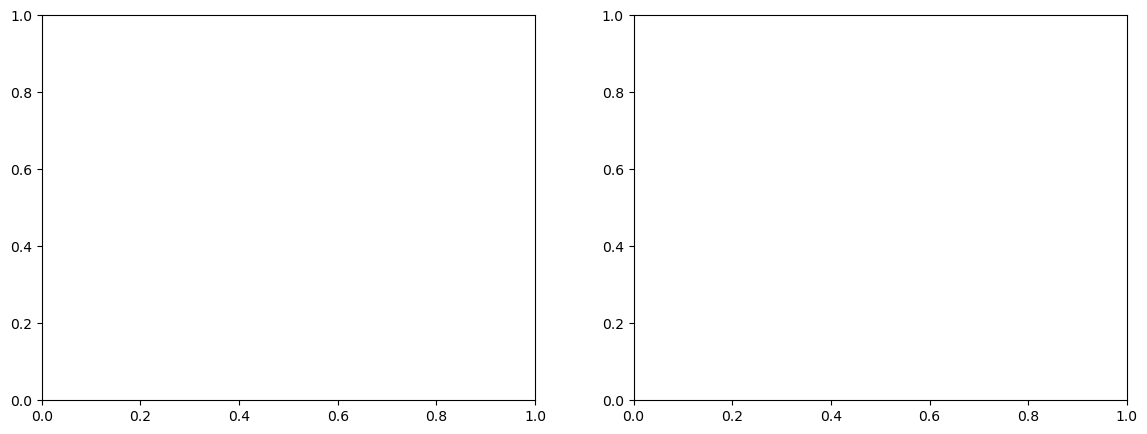

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# ===== 1) Read & window =====
file = "./data/EventAligned_BTC_ETH_1m_window_-60_to_120_ET_2024_FULL_cleanNFP.csv"
df = pd.read_csv(file)

df_win = df[df["OffsetMin"].between(-60, 120)].copy()

events = ["CPI", "NFP", "FOMC"]
ret_cols = ["BTC_ret_1m", "ETH_ret_1m"]

# Volume columns are optional: skip volume plots if missing
vol_cols_all = ["BTC_volume_1m", "ETH_volume_1m"]
vol_cols = [c for c in vol_cols_all if c in df.columns]

# ===== 2) Utility: safe plotting (only plot categories with data) with dynamic legend =====
def plot_by_category(ax, table, x, y, cats, label_title="Surprise"):
    plotted = False
    for cat in cats:
        sub = table[table["Category"] == cat]
        if not sub.empty and y in sub:
            ax.plot(sub[x], sub[y], marker="o", ms=3, label=cat)
            plotted = True
    ax.axvline(0, linestyle="--", alpha=0.8)
    ax.grid(True, alpha=0.3)
    if plotted:
        ax.legend(title=label_title)
    return plotted

# ===== 3) By event: compute means & plot =====
for evt in events:
    df_evt = df_win[df_win["EventType"] == evt].copy()
    if df_evt.empty:
        print(f"[Note] {evt} has no data in this window; skipped.")
        continue

    # (a) Mean table by Surprise × OffsetMin (returns & volume)
    mean_tbl = (
        df_evt.groupby(["Category", "OffsetMin"])[ret_cols + vol_cols]
              .mean().reset_index()
              .sort_values(["Category", "OffsetMin"])
    )

    # (b) CAR (cumulative sum of returns)
    car_tbl = mean_tbl.copy()
    for col in ret_cols:
        car_tbl[col + "_CAR"] = car_tbl.groupby("Category")[col].cumsum()

    # ---- Fig 1: AR (returns) ----
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
    for ax, col, title in zip(
        axes, ret_cols, ["BTC - AR (Return)", "ETH - AR (Return)"]
    ):
        plot_by_category(ax, mean_tbl, x="OffsetMin", y=col, cats=cats)
        ax.set_title(f"{evt}: {title}")
        ax.set_xlabel("Minutes around event")
        ax.set_ylabel("Average 1-min return")
    plt.tight_layout()
    plt.show()

    # ---- Fig 2: CAR (cumulative returns) ----
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
    for ax, col, title in zip(
        axes, ret_cols, ["BTC - CAR (Return)", "ETH - CAR (Return)"]
    ):
        plot_by_category(ax, car_tbl, x="OffsetMin", y=col+"_CAR", cats=cats)
        ax.set_title(f"{evt}: {title}")
        ax.set_xlabel("Minutes around event")
        ax.set_ylabel("Cumulative average return")
    plt.tight_layout()
    plt.show()

    # ---- Fig 3: Volume (1-min average) ----
    if vol_cols:
        fig, axes = plt.subplots(1, len(vol_cols), figsize=(7*len(vol_cols), 5), sharex=True)
        # Handle single-subplot case where axes is not iterable
        if len(vol_cols) == 1:
            axes = [axes]
        titles = [c.split("_")[0] + " - Volume (1m avg)" for c in vol_cols]
        for ax, col, title in zip(axes, vol_cols, titles):
            plot_by_category(ax, mean_tbl, x="OffsetMin", y=col, cats=cats)
            ax.set_title(f"{evt}: {title}")
            ax.set_xlabel("Minutes around event")
            ax.set_ylabel("Average 1-min volume")
        plt.tight_layout()
        plt.show()
    else:
        print(f"[Note] Volume columns {vol_cols_all} not found in file; volume plots skipped.")


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# ===== 0) Desktop path =====
desktop = os.path.join(os.path.expanduser("~"), "Desktop")

# ===== 1) Read & window =====
file = "./data/EventAligned_BTC_ETH_1m_window_-60_to_120_ET_2024_FULL_cleanNFP.csv"
df = pd.read_csv(file)

# Keep only the [-60, 120] window
df_win = df[df["OffsetMin"].between(-60, 120)].copy()

events  = ["CPI", "NFP", "FOMC"]
cats    = ["Above", "Below", "Equal"]

# Return & volume columns (use your original column names)
ret_cols = ["BTC_ret_1m", "ETH_ret_1m"]
vol_cols_all = ["BTC_volume_1m", "ETH_volume_1m"]
vol_cols = [c for c in vol_cols_all if c in df.columns]  # auto-detect existence

# Asset name mapping (for filenames & titles)
asset_map = {
    "BTC_ret_1m": "BTC",
    "ETH_ret_1m": "ETH",
    "BTC_volume_1m": "BTC",
    "ETH_volume_1m": "ETH",
}

# ===== 2) Plot as-is: line by category (keep markers) =====
def plot_by_category(ax, table, x, y, cats, label_title="Surprise"):
    """
    Plot lines by category on ax (original method: small circle markers). 
    Returns whether anything was plotted (to control legend visibility).
    """
    plotted = False
    for cat in cats:
        sub = table[table["Category"] == cat]
        if (not sub.empty) and (y in sub.columns):
            ax.plot(sub[x], sub[y], marker="o", ms=3, label=cat)  # keep original style
            plotted = True
    ax.axvline(0, linestyle="--", alpha=0.8)   # event timestamp
    ax.grid(True, alpha=0.3)
    if plotted:
        ax.legend(title=label_title)
    return plotted

# ===== 3) By event: compute means & generate/save plots one by one =====
for evt in events:
    df_evt = df_win[df_win["EventType"] == evt].copy()
    if df_evt.empty:
        print(f"[Note] {evt} has no data in this window, skipped.")
        continue

    # (a) Mean table by Surprise × OffsetMin (returns & volume)
    mean_tbl = (
        df_evt.groupby(["Category", "OffsetMin"])[ret_cols + vol_cols]
              .mean()
              .reset_index()
              .sort_values(["Category", "OffsetMin"])
    )

    # (b) CAR (cumulative sum of returns)
    car_tbl = mean_tbl.copy()
    for col in ret_cols:
        car_tbl[col + "_CAR"] = car_tbl.groupby("Category")[col].cumsum()

    # -----------------------------
    # Fig 1: AR (returns) — one for BTC, one for ETH
    # -----------------------------
    for col in ret_cols:
        asset = asset_map[col]
        fig, ax = plt.subplots(figsize=(12, 4))  # stretch x-axis
        plot_by_category(ax, mean_tbl, x="OffsetMin", y=col, cats=cats)
        ax.set_title(f"{evt}: {asset} - AR (Return)")
        ax.set_xlabel("Minutes around event")
        ax.set_ylabel("Average 1-min return")
        plt.tight_layout()
        out_path = os.path.join(desktop, f"{evt}_{asset}_AR.png")
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
        plt.close()
        print(f"[Saved] {out_path}")

    # -----------------------------
    # Fig 2: CAR (cumulative returns) — one for BTC, one for ETH
    # -----------------------------
    for col in ret_cols:
        asset = asset_map[col]
        fig, ax = plt.subplots(figsize=(12, 4))
        plot_by_category(ax, car_tbl, x="OffsetMin", y=col + "_CAR", cats=cats)
        ax.set_title(f"{evt}: {asset} - CAR (Return)")
        ax.set_xlabel("Minutes around event")
        ax.set_ylabel("Cumulative average return")
        plt.tight_layout()
        out_path = os.path.join(desktop, f"{evt}_{asset}_CAR.png")
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
        plt.close()
        print(f"[Saved] {out_path}")

    # -----------------------------
    # Fig 3: Volume (1-min average) — if columns exist, one for BTC and one for ETH
    # -----------------------------
    if vol_cols:
        for vcol in vol_cols:
            asset = asset_map[vcol]
            fig, ax = plt.subplots(figsize=(20, 4))
            plot_by_category(ax, mean_tbl, x="OffsetMin", y=vcol, cats=cats)
            ax.set_title(f"{evt}: {asset} - Volume (1m avg)")
            ax.set_xlabel("Minutes around event")
            ax.set_ylabel("Average 1-min volume")
            plt.tight_layout()
            out_path = os.path.join(desktop, f"{evt}_{asset}_Volume.png")
            plt.savefig(out_path, dpi=300, bbox_inches="tight")
            plt.close()
            print(f"[Saved] {out_path}")
    else:
        print(f"[Note] Volume columns {vol_cols_all} not found; volume plots skipped.")



[保存] C:\Users\王若禹\Desktop\CPI_BTC_AR.png
[保存] C:\Users\王若禹\Desktop\CPI_ETH_AR.png
[保存] C:\Users\王若禹\Desktop\CPI_BTC_CAR.png
[保存] C:\Users\王若禹\Desktop\CPI_ETH_CAR.png
[保存] C:\Users\王若禹\Desktop\CPI_BTC_Volume.png
[保存] C:\Users\王若禹\Desktop\CPI_ETH_Volume.png
[保存] C:\Users\王若禹\Desktop\NFP_BTC_AR.png
[保存] C:\Users\王若禹\Desktop\NFP_ETH_AR.png
[保存] C:\Users\王若禹\Desktop\NFP_BTC_CAR.png
[保存] C:\Users\王若禹\Desktop\NFP_ETH_CAR.png
[保存] C:\Users\王若禹\Desktop\NFP_BTC_Volume.png
[保存] C:\Users\王若禹\Desktop\NFP_ETH_Volume.png
[保存] C:\Users\王若禹\Desktop\FOMC_BTC_AR.png
[保存] C:\Users\王若禹\Desktop\FOMC_ETH_AR.png
[保存] C:\Users\王若禹\Desktop\FOMC_BTC_CAR.png
[保存] C:\Users\王若禹\Desktop\FOMC_ETH_CAR.png
[保存] C:\Users\王若禹\Desktop\FOMC_BTC_Volume.png
[保存] C:\Users\王若禹\Desktop\FOMC_ETH_Volume.png
